In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from conexao_banco_dados_resulth import ConexaoBancoDadosResulth
from repositorio_de_banco import FaturamentoReceber

In [2]:
with sqlite3.connect("db.areceber.sqlite3") as conn:
    df_pmr_giro = pd.read_sql_query("SELECT * FROM saldos;", conn)
    print(df_pmr_giro)

      id        DATA  REC_VENCIDOS  REC_NVENCIDOS  FATURAMENTO
0      1  2025-06-30     156238.97      546081.88   9572252.18
1      2  2025-07-01     156798.59      556299.54   9591334.18
2      3  2025-07-02     166672.00      559733.34   9596310.11
3      4  2025-07-03     162749.91      554301.68   9605242.11
4      6  2025-07-04     170181.84      553281.68   9602099.61
..   ...         ...           ...            ...          ...
130  132  2025-12-30     130912.77      429183.47  10495354.50
131  133  2025-12-31     130644.34      421076.63  10495990.00
132  134  2026-01-02     149734.75      410063.96  10488812.50
133  135  2026-01-05     167961.56      394705.09  10464980.20
134  136  2026-01-06     150825.06      401839.75  10509881.70

[135 rows x 5 columns]


### Quanto foi faturado a prazo?

In [3]:
consulta_faturamento = FaturamentoReceber(
    data_inicial="2025-01-01",
    data_final="2025-12-31",
    conexao=ConexaoBancoDadosResulth()
)
faturamento_receber = consulta_faturamento.processar_dados_faturamento_a_receber()
df_faturamento_receber = pd.DataFrame(faturamento_receber, columns=["DT_EMISSAO", "VL_TOTAL"])
df_faturamento_receber['DT_EMISSAO'] = pd.to_datetime(df_faturamento_receber['DT_EMISSAO'])

df_faturamento_receber

,DT_EMISSAO,VL_TOTAL
0,2025-01-02,6491.00
1,2025-01-03,16491.30
2,2025-01-04,19843.50
3,2025-01-06,9033.00
4,2025-01-07,19112.05
...,...,...
300,2025-12-26,14791.00
301,2025-12-27,6354.00
302,2025-12-29,19271.00
303,2025-12-30,10050.00


Cálculo da média móvel do faturamento

In [4]:
# Calculo da média móvel de 7 dias
df_faturamento_receber.set_index('DT_EMISSAO', inplace=True)
df_faturamento_receber['VL_TOTAL_MM7'] = df_faturamento_receber['VL_TOTAL'].rolling(window=7).mean()
df_faturamento_receber.reset_index(inplace=True)
df_faturamento_receber.dropna(inplace=True)

df_faturamento_receber

,DT_EMISSAO,VL_TOTAL,VL_TOTAL_MM7
6,2025-01-09,9419.07,12489.702857
7,2025-01-10,6327.00,12466.274286
8,2025-01-11,3068.00,10548.660000
9,2025-01-13,8580.00,8939.588571
10,2025-01-14,18934.00,10354.017143
...,...,...,...
300,2025-12-26,14791.00,8757.114286
301,2025-12-27,6354.00,9357.114286
302,2025-12-29,19271.00,11480.971429
303,2025-12-30,10050.00,11589.685714


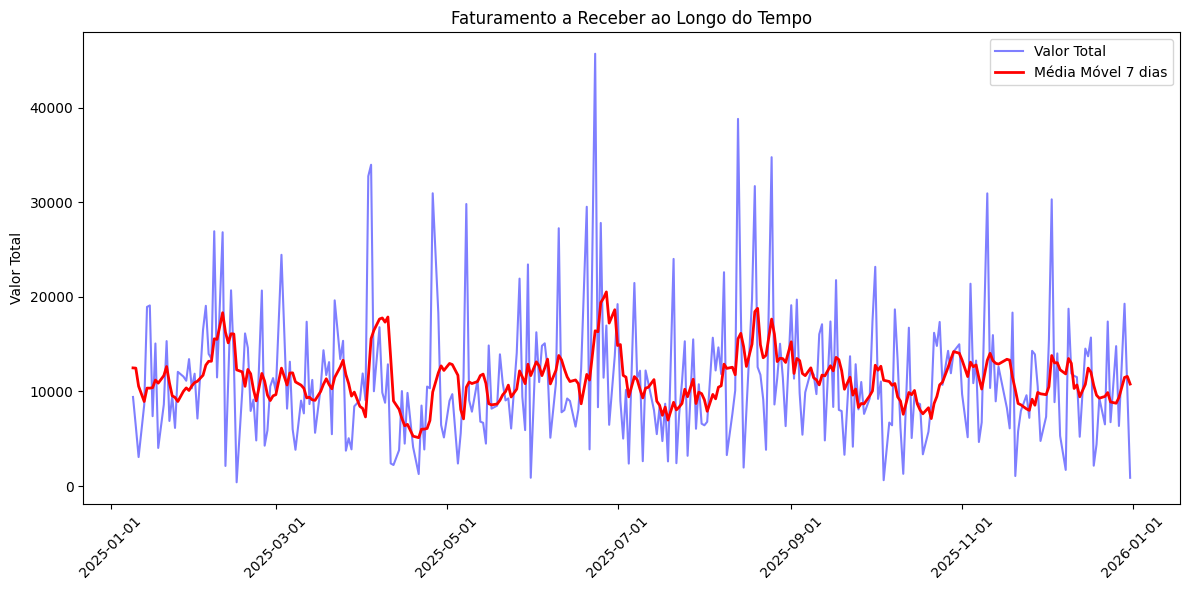

In [5]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_faturamento_receber['DT_EMISSAO'], df_faturamento_receber['VL_TOTAL'], label='Valor Total', color='blue', alpha=0.5)
# Plot da média móvel
ax.plot(df_faturamento_receber['DT_EMISSAO'], df_faturamento_receber['VL_TOTAL_MM7'], 
        label='Média Móvel 7 dias', color='red', linewidth=2)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Localizador automático
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formato da data
# Rotacionar labels para melhor visualização
plt.title("Faturamento a Receber ao Longo do Tempo")
plt.ylabel("Valor Total")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
# Estatísticas descritivas do DataFrame
print("Estatísticas Descritivas:")
print(df_faturamento_receber['VL_TOTAL'].describe())

print(f"\nTotal de registros: {len(df_faturamento_receber)}")
print(f"Período: {df_faturamento_receber['DT_EMISSAO'].min()} a {df_faturamento_receber['DT_EMISSAO'].max()}")

# Valores por dia
print("\nTop 10 dias com maior valor total:")
top_dias = df_faturamento_receber.sort_values(by='VL_TOTAL', ascending=False).head(10)
print(top_dias)

Estatísticas Descritivas:
count      299.000000
mean     11312.725719
std       6931.830634
min        400.000000
25%       6641.750000
50%      10022.000000
75%      14292.000000
max      45689.750000
Name: VL_TOTAL, dtype: float64

Total de registros: 299
Período: 2025-01-09 00:00:00 a 2025-12-31 00:00:00

Top 10 dias com maior valor total:
    DT_EMISSAO  VL_TOTAL  VL_TOTAL_MM7
143 2025-06-23  45689.75  16411.092857
187 2025-08-13  38805.80  15562.865714
197 2025-08-25  34758.00  17648.727143
78  2025-04-04  33958.75  15581.678571
77  2025-04-03  32755.00  11453.285714
192 2025-08-19  31703.09  18435.627143
96  2025-04-26  30945.00   9939.362857
262 2025-11-10  30934.00  13287.800000
281 2025-12-03  30303.00  13795.728571
105 2025-05-08  29810.00  10439.558571


Valor recebido dos clientes

In [7]:
# Processar dados faturamento recebido
faturamento_recebido = consulta_faturamento.processar_dados_faturamento_recebido()
df_faturamento_recebido = pd.DataFrame(faturamento_recebido, columns=["DT_EMISSAO", "VL_TOTAL"])
df_faturamento_recebido['DT_EMISSAO'] = pd.to_datetime(df_faturamento_recebido['DT_EMISSAO'])

df_faturamento_recebido

,DT_EMISSAO,VL_TOTAL
0,2025-01-02,6483.79
1,2025-01-03,16491.30
2,2025-01-04,19842.67
3,2025-01-06,9034.50
4,2025-01-07,19106.54
...,...,...
300,2025-12-26,421.00
301,2025-12-27,713.00
302,2025-12-29,1933.00
303,2025-12-30,4204.00


In [8]:
# Estatísticas descritivas do DataFrame
print("Estatísticas Descritivas:")
print(df_faturamento_recebido['VL_TOTAL'].describe())

print(f"\nTotal de registros: {len(df_faturamento_recebido)}")
print(f"Período: {df_faturamento_recebido['DT_EMISSAO'].min()} a {df_faturamento_recebido['DT_EMISSAO'].max()}")

# Valores por dia
print("\nTop 10 dias com maior valor total:")
top_dias = df_faturamento_recebido.sort_values(by='VL_TOTAL', ascending=False).head(10)
print(top_dias)

Estatísticas Descritivas:
count      305.000000
mean      9412.589672
std       6480.978993
min          0.000000
25%       5011.060000
50%       8521.000000
75%      12216.000000
max      36933.900000
Name: VL_TOTAL, dtype: float64

Total de registros: 305
Período: 2025-01-02 00:00:00 a 2025-12-31 00:00:00

Top 10 dias com maior valor total:
    DT_EMISSAO  VL_TOTAL
187 2025-08-13  36933.90
77  2025-04-03  32754.67
96  2025-04-26  30966.50
197 2025-08-25  30629.00
105 2025-05-08  29808.76
141 2025-06-20  29507.60
145 2025-06-25  27788.35
133 2025-06-10  27036.28
31  2025-02-07  26921.50
33  2025-02-10  25836.49


In [10]:
# Cálculo da média móvel de 7 dias
df_faturamento_recebido.set_index('DT_EMISSAO', inplace=True)
df_faturamento_recebido['VL_TOTAL_MM7'] = df_faturamento_recebido['VL_TOTAL'].rolling(window=7).mean()
df_faturamento_recebido.reset_index(inplace=True)
df_faturamento_recebido.dropna(inplace=True)

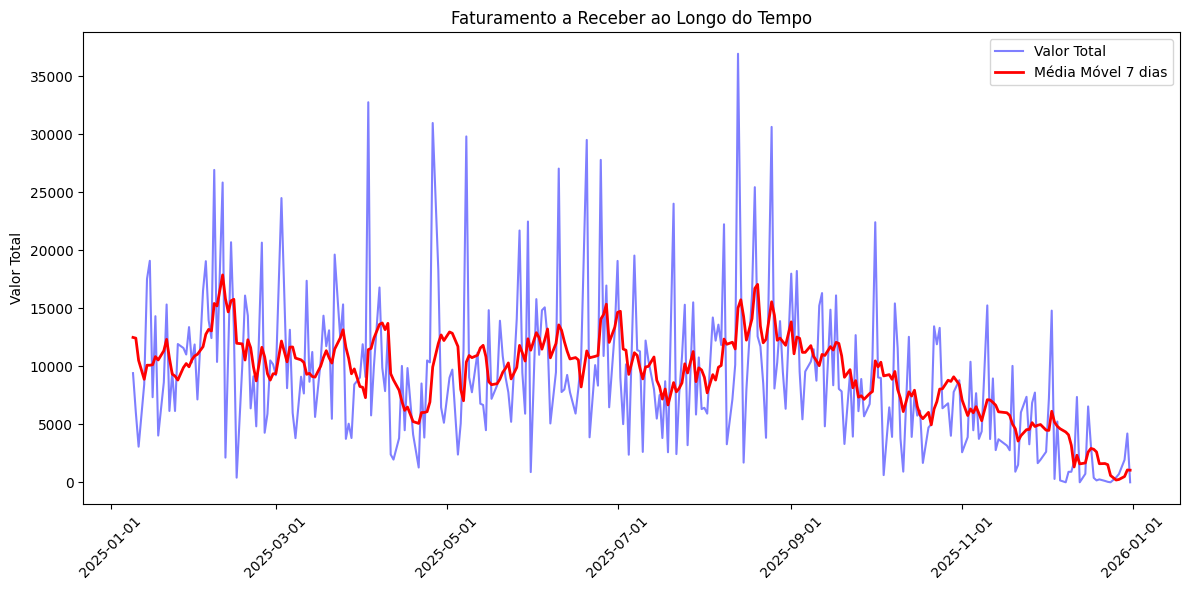

In [11]:
# Gráfico do faturamento recebido ao longo do tempo
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(df_faturamento_recebido['DT_EMISSAO'], df_faturamento_recebido['VL_TOTAL'], label='Valor Total', color='blue', alpha=0.5)
# Plot da média móvel
ax.plot(df_faturamento_recebido['DT_EMISSAO'], df_faturamento_recebido['VL_TOTAL_MM7'], 
        label='Média Móvel 7 dias', color='red', linewidth=2)
ax.xaxis.set_major_locator(mdates.AutoDateLocator())  # Localizador automático
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Formato da data
# Rotacionar labels para melhor visualização
plt.title("Faturamento a Receber ao Longo do Tempo")
plt.ylabel("Valor Total")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()